# Prepare the data

In [2]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import os

# Read in the dataset
trans_df = pd.read_csv(os.path.join("..", "data", "Final for clustering.csv"))

In [2]:
trans_df.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'No. of Litres',
       'Transaction Amount', 'VEHICLE MAKE', 'MODEL DERIVATIVE', 'DEPARTMENT',
       'RATE CARD CATEGORY', 'Site', 'District', 'Site Lat', 'Site Long',
       'Merchant Lat', 'Merchant Long', 'Fuel Type',
       'Estimated Price Per Litre', 'Coastal Petrol', 'Inland Petrol',
       'Coastal Diesel', 'Inland Diesel', 'Month Name', 'Weekday Name'],
      dtype='object')

In [3]:
trans_df.shape

(175933, 23)

In [4]:
# Select the columns for clustering
columns_for_clustering = ['No. of Litres',
       'Transaction Amount', 'Site Lat', 'Site Long',
       'Merchant Lat', 'Merchant Long']

# Keep only the rows without missing values for clustering
data_trans_clustering = trans_df[columns_for_clustering].dropna()

# Encode the categorical variables
data_trans_encoded = pd.get_dummies(data_trans_clustering)

# Identify and replace 'inf' and '-inf' with NaN
data_trans_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop 'NaN' values, maintaining the index
data_trans_encoded.dropna(inplace=True)

# Prepare data for clustering
X = data_trans_encoded.values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
X_scaled.shape

(175933, 6)

# k-means clustering

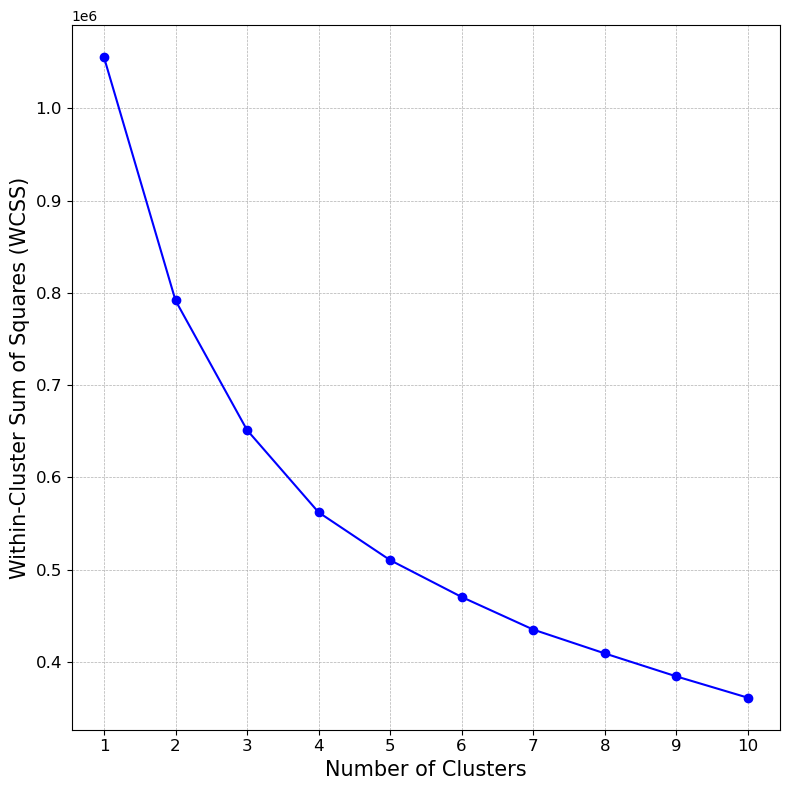

In [8]:
# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(1, 11): # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Create a professional-looking plot
plt.figure(figsize=(8, 8))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='blue')
#plt.title('Elbow Method for Optimal Number of Clusters', fontsize=18, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=15)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=15)
plt.xticks(range(1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../plots/transaction_clustering/kmeans_elbow_method_plot.pdf', format='pdf', dpi=300)

In [6]:
# Apply KMeans clustering
kclusts = 4
kmeans = KMeans(n_clusters=kclusts, init='k-means++', max_iter=300, n_init=10, random_state=1)
kmeans.fit(X_scaled)

# Add the cluster labels to the original dataset
trans_df['kmeans'] = kmeans.labels_

# BIRCH clustering

Silhouette Score for 2 clusters: 0.9696
Silhouette Score for 3 clusters: 0.5868
Silhouette Score for 4 clusters: 0.1538
Silhouette Score for 5 clusters: 0.1345
Silhouette Score for 6 clusters: 0.1427
Silhouette Score for 7 clusters: 0.1427
Silhouette Score for 8 clusters: 0.1437
Silhouette Score for 9 clusters: 0.1437
Silhouette Score for 10 clusters: 0.1431


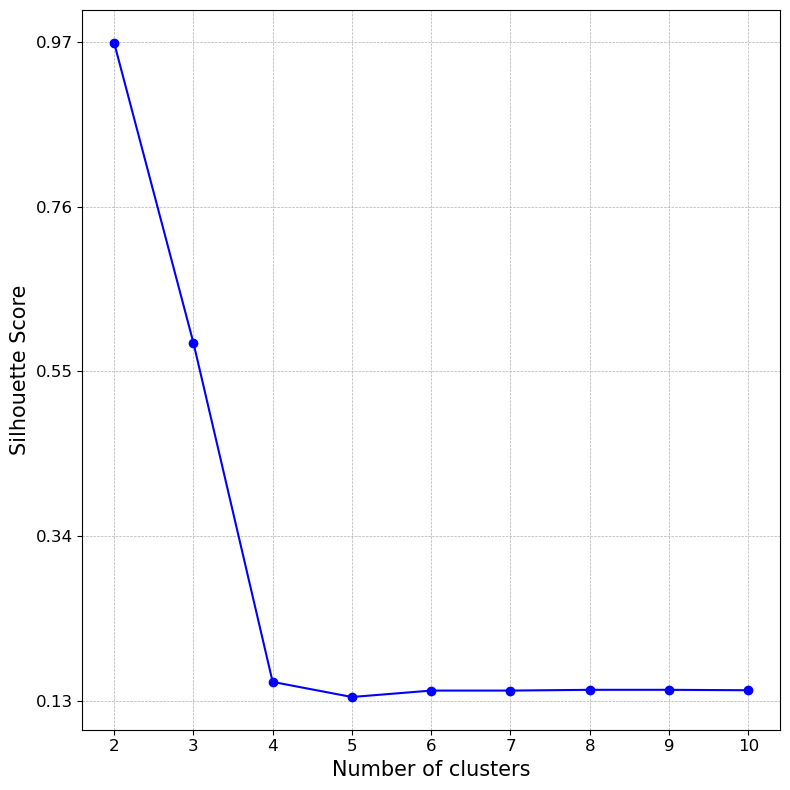

In [10]:
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np

range_n_clusters = list(range(2, 11))  # Example: evaluating from 2 to 10 clusters
silhouette_scores = []

for n_clusters in range_n_clusters:
    birch = Birch(n_clusters=n_clusters)
    cluster_labels = birch.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg:.4f}")

# Plotting silhouette scores with a more professional aesthetic
plt.figure(figsize=(8, 8))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of clusters', fontsize=15)
plt.ylabel('Silhouette Score', fontsize=15)
plt.xticks(range_n_clusters, fontsize=12)
plt.yticks(np.round(np.linspace(min(silhouette_scores), max(silhouette_scores), 5), 2), fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../plots/transaction_clustering/silhouette_scores_birch.pdf', format='pdf', dpi=150)

plt.show()

In [7]:
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_scaled is your scaled dataset
# Adjust the threshold and branching factor according to your dataset size and desired cluster granularity
brc = Birch(n_clusters=4)
brc.fit(X_scaled)

Birch(n_clusters=4)

In [8]:
trans_df['BirchCluster'] = brc.labels_

# Gaussian Mixture Model (GMM)

In [9]:
from sklearn.mixture import GaussianMixture

# If X_processed is a sparse matrix, convert it to a dense matrix
if isinstance(X_scaled, np.ndarray):
    X_dense = X_scaled
else:
    X_dense = X_scaled.toarray()

# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=kclusts, random_state=1)
gmm_labels = gmm.fit_predict(X_dense)

trans_df['GMMCluster'] = gmm_labels

# Plotting the results

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

def shorten_names(names, max_length=20):
    shortened_names = []
    for name in names:
        if len(name) > max_length:
            shortened_names.append(name[:max_length] + '...')
        else:
            shortened_names.append(name)
    return shortened_names


def four_stacked_plots(data, categorical_vars, cluster_var, titles, filename, max_categories=8, max_length=20, color_theme='tab10'):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.ravel()

    for i, (cat_var, title) in enumerate(zip(categorical_vars, titles)):
        # Calculate the proportions of each category in each cluster
        cluster_proportions = data.groupby([cluster_var, cat_var]).size().unstack(fill_value=0)
        cluster_proportions = cluster_proportions.div(cluster_proportions.sum(axis=1), axis=0)

        # Get the top categories and group the rest into "Others"
        top_categories = cluster_proportions.sum().nlargest(max_categories).index
        cluster_proportions["Others"] = cluster_proportions.drop(columns=top_categories).sum(axis=1)
        cluster_proportions = cluster_proportions[top_categories.tolist() + ["Others"]]

        # Shorten the category names if necessary
        shortened_names = shorten_names(cluster_proportions.columns, max_length=max_length)

        # Check if the cluster labels start from 0 or -1
        if cluster_proportions.index.min() == 0:
            # Shift the cluster labels up by 1 and rename them
            cluster_proportions.index = [str(i+1) for i in cluster_proportions.index]
        elif cluster_proportions.index.min() == -1:
            # Shift the cluster labels up by 1 (excluding -1) and rename them
            cluster_proportions.index = ["None" if i == -1 else str(i+1) for i in cluster_proportions.index]

        # Get the specified color theme
        color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
        colors = color_scheme(range(len(cluster_proportions.columns)))

        # Create the stacked bar chart in the corresponding subplot
        cluster_proportions.plot(kind='bar', stacked=True, ax=axs[i], legend=False, color=colors)

        axs[i].set_xticklabels(cluster_proportions.index, rotation=0, fontsize=12)
        axs[i].set_xlabel('Cluster', fontsize=14)
        axs[i].set_ylabel('Proportion', fontsize=14)
        axs[i].set_title(f"{chr(97+i)}) {title}")  # Prepend "a) ", "b) ", "c) ", "d) " to the titles

        # Create the legend for each subplot
        axs[i].legend(title='Categories', fontsize=10, labels=shortened_names, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.close(fig)

In [28]:
four_stacked_plots(trans_df,
                   ['MODEL DERIVATIVE', 'DEPARTMENT', 'District', 'RATE CARD CATEGORY'],
                   'kmeans',
                   ['Model Derivative', 'Department', 'District', 'Rate Card Category'],
                   '../plots/transaction_clustering/kmeans_clustered_vehicle_plots.pdf',
                   max_categories=5, max_length=15)

four_stacked_plots(trans_df,
                   ['MODEL DERIVATIVE', 'DEPARTMENT', 'District', 'RATE CARD CATEGORY'],
                   'BirchCluster',
                   ['Model Derivative', 'Department', 'District', 'Rate Card Category'],
                   '../plots/transaction_clustering/birch_clustered_vehicle_plots.pdf',
                   max_categories=5, max_length=15)

four_stacked_plots(trans_df,
                   ['MODEL DERIVATIVE', 'DEPARTMENT', 'District', 'RATE CARD CATEGORY'],
                   'GMMCluster',
                   ['Model Derivative', 'Department', 'District', 'Rate Card Category'],
                   '../plots/transaction_clustering/gmm_clustered_vehicle_plots.pdf',
                   max_categories=5, max_length=15)

/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_96979/2593190883.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_96979/2593190883.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_96979/2593190883.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps